Here is some code where I am messing around with building a convolutional neural network using some examples from the internet. I've writted notes about how this needs to be modified for our analysis.

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [5]:
!pip uninstall numpy -y
!pip install numpy==1.23.1

Found existing installation: numpy 1.23.1
Uninstalling numpy-1.23.1:
  Successfully uninstalled numpy-1.23.1


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 189, in _main
    status = self.run(options, args)
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_internal\commands\uninstall.py", line 91, in run
    uninstall_pathset.commit()
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 456, in commit
    self._moved_paths.commit()
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 296, in commit
    save_dir.cleanup()
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_internal\utils\temp_dir.py", line 205, in cleanup
    rmtree(ensure_text(self._path))
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_vendor\retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "C:\Users\44738\anaconda3\lib\site-packages\pip\_vendor\retrying.py", line 212, in call
    ra

  Using cached numpy-1.23.1-cp38-cp38-win_amd64.whl (14.7 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.1 which is incompatible.


In [6]:
!pip install tensorflow

In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import numpy as np
import pandas as pd
import awkward as ak

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get data

Download the mnist data base from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz then load in the data. For me, keras wasn't able to automatically download the data so I had to go to the url and download the data by hand before loading the data, as shown below.

In [8]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
data_path = 'padded_waveforms.parquet'
arr = ak.from_parquet(data_path)
ak.fields(arr)

['runID',
 'eventID',
 'times',
 'samples',
 'length',
 'area',
 'max_pulse_height',
 'ext_elec',
 'x',
 'y',
 'r',
 'S2_width',
 'label',
 'type',
 'weights_no_gas',
 'chonkers']

The data are 2D greyscale images of handwritten numbers with intensity in the range 0-255. The data must be rescaled by dividing by 255, then flattened into 1D arrays.

In our case, we will be using 1D 'images' and the range will be between 0 and the maximum height reached within any one of the pulses. We don't know what this is ahead of time; you'll have to find the maximum then divide all the images by that number. I think we will also need to pad the arrays to make them the same length, since each pulse will have a variable number of samples. I would start by adding zeroes evenly to the front and back of the array. I'm not sure if the way we do this could introduce some difficulties in learning for the CNN. We should think about this a little bit.

In [9]:
import awkward as ak

# Assuming 'times' and 'samples' are the column names
# Normalize each array in the 'times' and 'samples' columns

# Function to normalize arrays to values between 0 and 1
def normalize_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalized_times = normalize_array(arr['times'])
normalized_samples = normalize_array(arr['samples'])



# Print or inspect the results
print(normalized_times)
print(normalized_samples)

[[0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.997, 0.998, 0.999, 1], ...]
[[0.00238, 0.00212, 0.00198, 0.00223, ..., 0.00251, 0.00211, 0.00133, 0], ...]


In [10]:
import awkward as ak
import numpy as np
from sklearn.model_selection import train_test_split


# Determine the maximum length in both normalized arrays
max_length = max(ak.max(ak.num(normalized_times, axis=-1)), ak.max(ak.num(normalized_samples, axis=-1)))

# Pad each array to the same maximum length
padded_times = ak.fill_none(ak.pad_none(normalized_times, target=max_length, axis=-1), 0)
padded_samples = ak.fill_none(ak.pad_none(normalized_samples, target=max_length, axis=-1), 0)

# Convert padded arrays to numpy and concatenate
padded_times_np = ak.to_numpy(padded_times)
padded_samples_np = ak.to_numpy(padded_samples)

X_combined = np.concatenate([padded_times_np, padded_samples_np], axis=1)
print("X_combined shape:", X_combined.shape)

labels = arr['label']

labels = np.array(labels)

print("labels shape:", labels.shape)

X_combined shape: (7782, 3656)
labels shape: (7782,)


In [11]:
# Split X_combined and labels into 25% training and 75% test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.25, random_state=42)

# Verify the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5836, 3656)
X_test shape: (1946, 3656)
y_train shape: (5836,)
y_test shape: (1946,)


# Sequential fully-connected neural network with only input and output layers

This is a sequential fully-connected neural network with only input and output layers. The input shape is (784,) because each 28x28 image has been flattened into a 784x1 tensor. Each element of the tensor is fed into one of the 784 neurons of the input layer. The output shape is 10 because there are 10 different numbers that can be written in the image: 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9. The term "sequential" indicates the model is a plain stack of layers, which works in a basic scenario where every layer has a single input tensor and a single output tensor. The term "fully-connected" refers to the fact that each one of the 784 input neurons is connected to each one of the 10 output neurons. Generally, the activation function for the output layer is a sigmoid that scales the output of each neuron to within the range 0-1. This makes it appear to be a probability, but I think it's not a probability and we shouldn't call it that.

The configuration described above can be adapted to our case. The input shape will be the paded length of the waveforms, the output shape will be 3 for a 0 (signal-like), 1 (gate-like), or 2 (cathode-like) S2.

Some resources for learning or remembering what a neural network does are: https://victorzhou.com/blog/intro-to-neural-networks/ (simple description of a neural network) and https://keras.io/guides/sequential_model/ (basic description of how to write the code using keras). You may already have experience with this from your courses - I'm not sure what they teach these days - but it's not a big deal if you have no experience because there are lots of resources online.

In [12]:
simpleNN = keras.Sequential([
    keras.layers.Dense(3,input_shape=(3656,),activation='sigmoid')
])

simpleNN.summary()

#this sets up our sequential fully-connected neural network with only an input and output layer
#keras.Sequential() creastes the model- layers stached one after another linearky
#the 10 defines a fully connected dense layer with 10 neurons
#input_shape(784,)- just says the shape of the input data (784 pixels)
#sigmoid just applies the sigmoid activation function to each neuron0 this sigmoid function outputs values between 0 and 1
#the last command just prints a summary of the models architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 10971     
                                                                 
Total params: 10971 (42.86 KB)
Trainable params: 10971 (42.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The loss function for multi-class classification should be sparse categorical crossentropy. This will work for our case as well, since we have 3 categories. We could also try a case were we have an output shape of 2  with 0 = signal-like and 1 = gate/cathode-like, using binary crossentropy. Was there any similar issue with the hyperparameters for the multiclass boosted decision tree.

In [13]:
simpleNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

#this function prepares the model for training
#optimiser- updates weights of the network based on the gradients calculated via backpropagation
#loss- tells the network how wrong the predictions are
#metrics- used to tell you the perfromance of the model here we specify the accuracy as the metric

One epoch corresponds to running the data through the neural network, calculating the loss, and reweighting the model. We will have to weight the samples evenly across S2 size, like  we did for the boosted decision tree. I think this is done by setting the paramter sample_weight equal to your sample weights in the fit function, below. We will also have to decide how many epochs to use by plotting accuracy vs epoch, as you've done for the boosted decision tree, and comparing the accuracy of the test and training datasets, which should be the ~same at the end if you aren't overtraining.

In [14]:
simpleNN.fit(X_train,y_train,epochs=5)
# here we train the data, epochs is the numbers of times the data gets trained
#X_train_flattened- input training data
#y_train is the true value of the data that we use for comparison and what the model tried to predict

Epoch 1/5
183/183 [==============================] - 1s 2ms/step - loss: 0.3832 - accuracy: 0.8367
Epoch 2/5
183/183 [==============================] - 0s 2ms/step - loss: 0.3393 - accuracy: 0.8571
Epoch 3/5
183/183 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy: 0.8609
Epoch 4/5
183/183 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.8614
Epoch 5/5
183/183 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.8634


In [15]:
simpleNN.evaluate(X_test,y_test)
#this evaluates the trained model
#X_test_flattened- test input data
#y_test: true labels for the data

61/61 [==============================] - 0s 1ms/step - loss: 0.3484 - accuracy: 0.8582


[0.3483726680278778, 0.8581706285476685]

It's also nice to plot a confusion matrix to understand what is getting misclassified. This might be good to do making cuts on S2 size, especially if the accuracy vs epoch plot shows that some S2 sizes are improving while others are not.

In [16]:
y_predicted = simpleNN.predict(X_test)
y_predicted_label = [np.argmax(i) for i in y_predicted]

y_predicted[0], y_predicted_label[0]

#first line produces predicted probabilities for each class i.e digits 0-9 for each image
#the ouput y_predicted would create an erray corresponding to all the pixels in the image giving it a probability (i.e. 784 pixels with 0-9 digit)
#2nd line line converts the probability array into a class label
#np.argmax{i}, finds the index of the highest value in each array- this index corresponds to the predicted class (digit)
#y_predicted_label[0]- returns the predicted label for the first test image

61/61 [==============================] - 0s 1ms/step


(array([0.52602935, 0.0012083 , 0.8971098 ], dtype=float32), 2)

Text(59.0, 0.5, 'Truth')

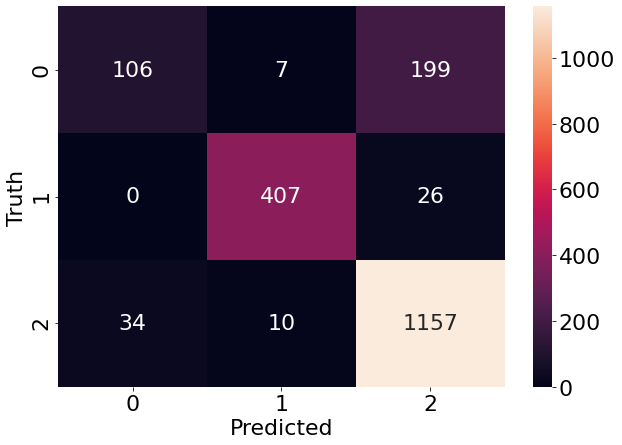

In [17]:
plt.figure(figsize = (10,7))
sn.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
           annot=True, 
           fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#line sets up a new figure for the plot with size 10* 7 inches
#sn.heatmap creates a matrix which shows you how many times the predicted labels match the true labels
#tf.math.confusion_matrix() generates this confusion matrix using tensor flow
#the labels within the matrix show you your true result in y axis and predicted result in x axis

# Adding a hidden layer

Adding a hidden layer can increase performance but will take longer to run. We'll have to think about how to optimize the number of hidden layers and the number of neurons in each hidden layer. Below, there is one hidden layer with 100 neurons. The activation function is a rectified linear unit (ReLU), which helps to improve performance. Hidden layers usually have ReLU or Leaky ReLU functions.

In [18]:
hiddenNN = keras.Sequential([
    keras.layers.Dense(100,input_shape=(3656,),activation='relu'),
    keras.layers.Dense(3,activation='sigmoid')
])
hiddenNN.summary()

#keras.sequential([])- creates a sequential model
#first layer is the hidden layer, second layer is the output layer
#layer 1, is fully connected with 100 neurons, with input of 784 length arrays
#layer 2, is output layer, which is a fully connected layer with 10 neurons
#then we print out the summary of hte model shown below

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               365700    
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 366003 (1.40 MB)
Trainable params: 366003 (1.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
hiddenNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

hiddenNN.fit(X_train,y_train,epochs=5)

Epoch 1/5
183/183 [==============================] - 2s 6ms/step - loss: 0.3651 - accuracy: 0.8463
Epoch 2/5
183/183 [==============================] - 1s 5ms/step - loss: 0.3079 - accuracy: 0.8681
Epoch 3/5
183/183 [==============================] - 1s 5ms/step - loss: 0.2888 - accuracy: 0.8765
Epoch 4/5
183/183 [==============================] - 1s 7ms/step - loss: 0.2782 - accuracy: 0.8806
Epoch 5/5
183/183 [==============================] - 1s 7ms/step - loss: 0.2657 - accuracy: 0.8869


In [20]:
hiddenNN.evaluate(X_test,y_test)

61/61 [==============================] - 0s 2ms/step - loss: 0.2900 - accuracy: 0.8803


[0.28996115922927856, 0.8802672028541565]

# Convolutional neural network

Convolutional layers should improve the accuracy further but will even longer to run. You should try to understand what filters, pooling, and kernal size are. These are the hyperparameters you need to mess around with, as well as the number of convolutional layers. The filters will be used to look for certain features of the S2 waveforms so I think the kernal size should be decided based on the size of features you are trying to select. Here is a descriptive link: https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=A%20convolutional%20neural%20network%20is,classify%20objects%20in%20an%20image. This made my computer start to overheat, hence the desire to use a gpu, but maybe we are okay.

In [21]:
#convoNN = keras.Sequential([
#    keras.layers.Conv2D(filters=28,kernel_size=(3,3),activation='relu', input_shape=(28,28,1)),
#    keras.layers.MaxPooling2D((2, 2)),
    
#    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu'),
#    keras.layers.MaxPooling2D((2, 2)),
    
#    keras.layers.Flatten(),
#    keras.layers.Dense(64, activation='relu'),
#    keras.layers.Dense(3, activation='softmax')
#])


#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2,2) specifies a pooling window which means the layer will take the max value from every 2*2 region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

In [22]:
from tensorflow import keras

# Adjusted model to work with 1D input data
convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [24]:
convoNN.fit(X_train, y_train, epochs=5)

Epoch 1/5
183/183 [==============================] - 18s 92ms/step - loss: 0.3546 - accuracy: 0.8424
Epoch 2/5
183/183 [==============================] - 18s 98ms/step - loss: 0.3086 - accuracy: 0.8660
Epoch 3/5
183/183 [==============================] - 18s 98ms/step - loss: 0.2799 - accuracy: 0.8799
Epoch 4/5
183/183 [==============================] - 23s 124ms/step - loss: 0.2631 - accuracy: 0.8862
Epoch 5/5
183/183 [==============================] - 22s 121ms/step - loss: 0.2379 - accuracy: 0.8982


In [25]:
# Reshape to add a channel dimension for the 1D CNN
X_test_reshaped = X_test.reshape(-1, 3656, 1)

# Evaluate the model
convoNN.evaluate(X_test_reshaped, y_test)


61/61 [==============================] - 2s 24ms/step - loss: 0.2960 - accuracy: 0.8834


[0.29600489139556885, 0.8833504915237427]

In [26]:
#convoNN.evaluate(X_test_flattened,y_test)